# Linear Regression Consulting Project

Congratulations! You've been contracted by Hyundai Heavy Industries to help them build a predictive model for some ships. [Hyundai Heavy Industries](http://www.hyundai.eu/en) is one of the world's largest ship manufacturing companies and builds cruise liners.

You've been flown to their headquarters in Ulsan, South Korea to help them give accurate estimates of how many crew members a ship will require.

They are currently building new ships for some customers and want you to create a model and use it to predict how many crew members the ships will need.

Here is what the data looks like so far:

    Description: Measurements of ship size, capacity, crew, and age for 158 cruise
    ships.


    Variables/Columns
    Ship Name     1-20
    Cruise Line   21-40
    Age (as of 2013)   46-48
    Tonnage (1000s of tons)   50-56
    passengers (100s)   58-64
    Length (100s of feet)  66-72
    Cabins  (100s)   74-80
    Passenger Density   82-88
    Crew  (100s)   90-96
    
It is saved in a csv file for you called "cruise_ship_info.csv". Your job is to create a regression model that will help predict how many crew members will be needed for future ships. The client also mentioned that they have found that particular cruise lines will differ in acceptable crew counts, so it is most likely an important feature to include in your analysis! 

Once you've created the model and tested it for a quick check on how well you can expect it to perform, make sure you take a look at why it performs so well!

# Notes

- cruise lines will be important feature
  - use `StringIndexer`, see documentation

# Start

In [2]:
import pyspark
spark = pyspark.sql.SparkSession.builder.appName("app").getOrCreate()

In [36]:
df = spark.read.csv(
    "/home/jovyan/udemy_pyspark/resources/Spark_for_Machine_Learning/Linear_Regression/cruise_ship_info.csv",
    inferSchema=True,
    header=True,
)
df.printSchema()
df.head()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



Row(Ship_name='Journey', Cruise_line='Azamara', Age=6, Tonnage=30.276999999999997, passengers=6.94, length=5.94, cabins=3.55, passenger_density=42.64, crew=3.55)

In [4]:
df.describe().show()

+-------+---------+-----------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|summary|Ship_name|Cruise_line|               Age|           Tonnage|       passengers|           length|            cabins|passenger_density|             crew|
+-------+---------+-----------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|  count|      158|        158|               158|               158|              158|              158|               158|              158|              158|
|   mean| Infinity|       null|15.689873417721518| 71.28467088607599|18.45740506329114|8.130632911392404| 8.830000000000005|39.90094936708861|7.794177215189873|
| stddev|     null|       null| 7.615691058751413|37.229540025907866|9.677094775143416|1.793473548054825|4.4714172221480615| 8.63921711391542|3.503486564627034|
|    min|Adventure|    Azamara|   

# EDA

- crew ranges from 0.59 to 21.0
- Table has 158 rows
- Most columns are numbers except for Ship_name and Cruise_line. How many distinct values do they have?

In [7]:
df.select("Ship_name").distinct().count()

138

In [9]:
df.select("Cruise_line").distinct().count()

20

-> Okay, use all features except ship_name (or try out...).

# Feature extraction

In [13]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer, VectorAssembler

df.columns

['Ship_name',
 'Cruise_line',
 'Age',
 'Tonnage',
 'passengers',
 'length',
 'cabins',
 'passenger_density',
 'crew']

In [29]:
# Convert strings to numbers
indexer = StringIndexer(
    inputCols=["Cruise_line", "Ship_name"],
    outputCols=["Cruise_line_number", "Ship_name_number"],
)
indexer_model = indexer.fit(df)
new_df = indexer_model.transform(df)
new_df.head()

Row(Ship_name='Journey', Cruise_line='Azamara', Age=6, Tonnage=30.276999999999997, passengers=6.94, length=5.94, cabins=3.55, passenger_density=42.64, crew=3.55, Cruise_line_number=16.0, Ship_name_number=64.0)

In [28]:
new_df.columns

['Ship_name',
 'Cruise_line',
 'Age',
 'Tonnage',
 'passengers',
 'length',
 'cabins',
 'passenger_density',
 'crew',
 'Cruise_line_number',
 'Ship_name_number']

In [42]:
selected_columns =[
#    'Ship_name',
# 'Cruise_line',
 'Age',
 'Tonnage',
 'passengers',
 'length',
 'cabins',
 'passenger_density',
# 'crew',  # target
 'Cruise_line_number', 
# 'Ship_name_number',  # likely will overfit?
]

In [43]:
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")
features = assembler.transform(new_df)
features.printSchema()
features.head()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)
 |-- Cruise_line_number: double (nullable = false)
 |-- Ship_name_number: double (nullable = false)
 |-- features: vector (nullable = true)



Row(Ship_name='Journey', Cruise_line='Azamara', Age=6, Tonnage=30.276999999999997, passengers=6.94, length=5.94, cabins=3.55, passenger_density=42.64, crew=3.55, Cruise_line_number=16.0, Ship_name_number=64.0, features=DenseVector([6.0, 30.277, 6.94, 5.94, 3.55, 42.64, 16.0]))

In [44]:
final_data = features.select(
    "features",
    "crew",
)
final_data.show()

+--------------------+----+
|            features|crew|
+--------------------+----+
|[6.0,30.276999999...|3.55|
|[6.0,30.276999999...|3.55|
|[26.0,47.262,14.8...| 6.7|
|[11.0,110.0,29.74...|19.1|
|[17.0,101.353,26....|10.0|
|[22.0,70.367,20.5...| 9.2|
|[15.0,70.367,20.5...| 9.2|
|[23.0,70.367,20.5...| 9.2|
|[19.0,70.367,20.5...| 9.2|
|[6.0,110.23899999...|11.5|
|[10.0,110.0,29.74...|11.6|
|[28.0,46.052,14.5...| 6.6|
|[18.0,70.367,20.5...| 9.2|
|[17.0,70.367,20.5...| 9.2|
|[11.0,86.0,21.24,...| 9.3|
|[8.0,110.0,29.74,...|11.6|
|[9.0,88.5,21.24,9...|10.3|
|[15.0,70.367,20.5...| 9.2|
|[12.0,88.5,21.24,...| 9.3|
|[20.0,70.367,20.5...| 9.2|
+--------------------+----+
only showing top 20 rows



# Split data

In [45]:
train_data, test_data = final_data.randomSplit([0.7,0.3])
train_data.describe().show()
test_data.describe().show()

+-------+------------------+
|summary|              crew|
+-------+------------------+
|  count|               104|
|   mean| 7.547019230769242|
| stddev|3.3567890574663193|
|    min|              0.59|
|    max|              19.1|
+-------+------------------+

+-------+-----------------+
|summary|             crew|
+-------+-----------------+
|  count|               54|
|   mean|8.270185185185188|
| stddev|3.756472899450318|
|    min|             0.88|
|    max|             21.0|
+-------+-----------------+



In [46]:
from pyspark.ml.regression import LinearRegression
trainer = LinearRegression(labelCol="crew")
model = trainer.fit(train_data)

In [48]:
test_results = model.evaluate(test_data)
(
    # test_results.residuals.show(),
    test_results.rootMeanSquaredError,
    test_results.r2,  # 
)

(0.9644626394309781, 0.9328372936221354)

- R^2 of 0.93 seems good.
- RMSE of 0.96 seems also decent, given that from 0.59 to 21.0

# Manual evaluation

In [52]:
results = model.transform(test_data)
results.show()

+--------------------+-----+------------------+
|            features| crew|        prediction|
+--------------------+-----+------------------+
|[4.0,220.0,54.0,1...| 21.0| 20.94009878706831|
|[5.0,122.0,28.5,1...|  6.7| 6.084794761617925|
|[5.0,133.5,39.59,...|13.13|13.164593286547088|
|[6.0,30.276999999...| 3.55| 4.302207723566393|
|[6.0,113.0,37.82,...| 12.0|11.770406395693806|
|[7.0,89.6,25.5,9....| 9.87|11.068145585711907|
|[7.0,158.0,43.7,1...| 13.6|13.884430637628817|
|[8.0,77.499,19.5,...|  9.0| 8.546491690997469|
|[9.0,113.0,26.74,...|12.38|11.288749405771716|
|[9.0,113.0,26.74,...|12.38|11.288749405771716|
|[9.0,116.0,26.0,9...| 11.0|11.092031465760522|
|[10.0,68.0,10.8,7...| 6.36| 6.545790373944432|
|[10.0,105.0,27.2,...|10.68|11.238954865127381|
|[10.0,110.0,29.74...| 11.6|12.093884286685268|
|[10.0,138.0,31.14...|11.85|12.913543210324416|
|[11.0,58.6,15.66,...|  7.6| 7.360551242105292|
|[11.0,91.62700000...|  9.0|  9.10419806453487|
|[12.0,77.104,20.0...| 9.59| 8.736250631

In [70]:
!pip install plotly-express jupyter-dash "ipywidgets>=7.6"

In [ ]:
# !jupyter labextension install jupyterlab-plotly 

In [65]:
import plotly.express as px

In [66]:
result_df = results.toPandas()
result_df.head()

,features,crew,prediction
0,"[4.0, 220.0, 54.0, 11.82, 27.0, 40.74, 0.0]",21.00,20.940099
1,"[5.0, 122.0, 28.5, 10.33, 6.87, 34.57, 6.0]",6.70,6.084795
2,"[5.0, 133.5, 39.59, 10.93, 16.37, 33.72, 7.0]",13.13,13.164593
3,"[6.0, 30.276999999999997, 6.94, 5.94, 3.55, 42...",3.55,4.302208
4,"[6.0, 113.0, 37.82, 9.51, 15.57, 29.88, 2.0]",12.00,11.770406


In [72]:
!pip install matplotlib

Text(0, 0.5, 'crew_pred')

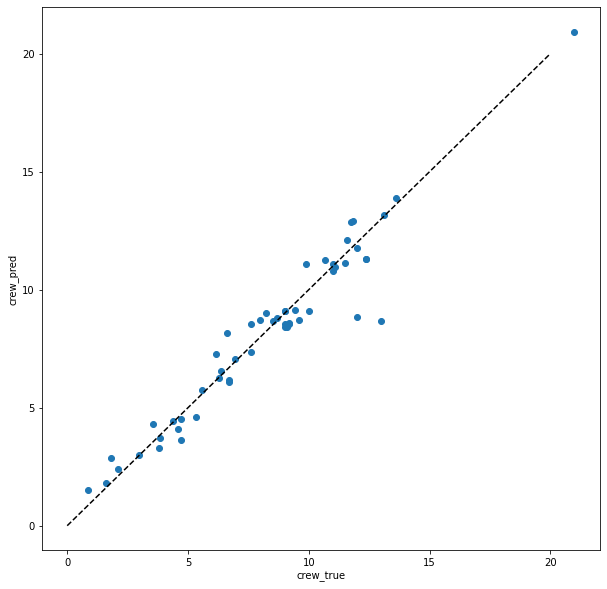

In [78]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(result_df["crew"], result_df["prediction"])
ax.plot([0,20],[0,20], "k--")
ax.set_xlabel("crew_true")
ax.set_ylabel("crew_pred")